# Read

The data of the selected pairs to trade.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import *
from itertools import product
from sklearn.linear_model import Ridge
from utils import log

In [2]:
filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)
display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,SPY_ETF,AVAXUSDT,0.869979,-3.278551,0.015865,True,-3.598971,0.024574,True
3,SPY_ETF,ETHUSDT,0.890225,-3.433397,0.009872,True,-3.693317,0.018691,True
4,EQQQ_ETF,BNBUSDT,0.898875,-3.915881,0.001921,True,-3.961015,0.008155,True
5,BNBUSDT,ADAUSDT,0.892662,-3.052379,0.030284,True,-3.509109,0.031596,True
6,BNBUSDT,ETHUSDT,0.921440,-3.114948,0.025467,True,-3.432310,0.038886,True
7,BNBUSDT,TRXUSDT,0.945392,-3.996231,0.001430,True,-4.200755,0.003638,True
8,BNBUSDT,XRPUSDT,0.931496,-4.213361,0.000625,True,-4.639767,0.000715,True
9,TRXUSDT,XRPUSDT,0.933322,-3.358503,0.012458,True,-3.623223,0.022926,True


We have the following pairs to trade:
- GOOG - GOOGL: Google Series A and Google Series C - since both securities depict the performance of the same company, we do not want to consider this pair in our portfolio
- META - DAX ETF
- S&P 500 ETF and AVAXUDST: S&P 500 ETF and Avalanche cryptocurrency
- S&P 500 ETF and ETHUDST: S&P 500 ETF and Ethereum cryptocurrency
- EQQQ ETF and BNBUSDT: Nasdaq 100 ETF and Binance coin cryptocurrency
- BNBUSDT and ADAUSDT: Binance coin and Cardano cryptocurrency
- BNBUSDT and ETHUDST: Binance coin and Ethereum cryptocurrency
- BNBUSDT and TRXUDST: Binance coin and TRON cryptocurrency
- BNBUSDT and XRPUDST: Binance coin and XRP (Ripple) cryptocurrency
- TRXUDST and XRPUDST: TRON cryptocurrency and XRP (Ripple) cryptocurrency.

As we can see, the portfolio is composed mostly of cryptocurrencies, but there is also an equity pair (Meta/DAX ETF) as well as equity-cryptocurrency pairs: S&P 500 ETF/Avalanche and S&P 500 ETF/Ethereum. Such a composition, in hindsight, should not come as a surprise because:
- Numerous cryptocurrency pairs are driven by similar factors and in this market events on all tradeable coins are still mostly driven by Bitcoin, hence high correlations and time-invariant spreads are fairly expected
- Equity-cryptocurrency pairs: S&P 500 ETF against Avalanche and Ethereum reflect the increasing interest in and integration of the traditional financial markets and digital assets
- The equity-equity pair Meta/DAX ETF suggests a potential macroeconomic link: Meta is a global tech giant while DAX represents the broader European market; hence these two correlating may be drien by similar trends and/or risk sentiments.

In [3]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
df_full = pd.read_csv('df_full.csv').drop(['Unnamed: 0'], axis=1)
df_full = df_full[df_full['Symbol'].isin(unique_tickers)].copy().reset_index(drop=True)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT ETHUSDT
BNBUSDT TRXUSDT
BNBUSDT XRPUSDT
TRXUSDT XRPUSDT
********************
Unique tickers:
META
SPY_ETF
EQQQ_ETF
BNBUSDT
TRXUSDT
DAXEX_ETF
AVAXUSDT
ETHUSDT
ADAUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
149263,2024-12-19 16:35:00,39.1500,39.3800,39.0800,39.3000,AVAXUSDT
153214,2024-12-21 23:25:00,0.2453,0.2457,0.2452,0.2457,TRXUSDT
72508,2024-11-05 06:30:00,0.1618,0.1620,0.1616,0.1619,TRXUSDT
14070,2024-12-30 14:30:00,591.4750,592.9500,591.4750,592.8000,META
146917,2024-12-18 08:00:00,46.2900,46.4300,46.2500,46.3000,AVAXUSDT


## Prepare Spreads of the Final Pairs

Once we have the pairs series prepared and aligned in time, we can proceed with spread calculation. Spread between two assets at time $t$ is given directly as the difference between two asset prices, i.e., $$\text{Spread}_{AB, t} = p_{A,t} - p_{B, t}$$ where $p_A$ - price of asset A and $p_B$ - price of asset B.

The next step is to normalize the spread by subtracting the mean and dividing by standard deviation, given as $$\text{Normalized Spread}_t = \frac{\text{Spread}_{AB, t} - \mu_{\text{Spread}_{AB}}}{\sigma_{\text{Spread}_{AB}}}$$

In the base case scenario, a **trading signal** is identified when spread is below -2 or above 2 with the following interpretation:
- $\text{Spread}_{AB, t} < -2$: buy A, sell B
- $\text{Spread}_{AB, t} > 2$: buy B, sell A.

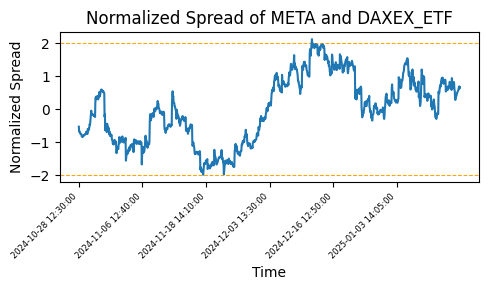

,META,DAXEX_ETF,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-28 12:30:00,580.450,162.10,418.350,-0.524746,NaN,No action
2024-10-28 12:35:00,577.670,162.10,415.570,-0.671628,-0.524746,No action
2024-10-28 13:00:00,577.755,162.04,415.715,-0.663967,-0.671628,No action
2024-10-28 13:10:00,577.320,162.08,415.240,-0.689064,-0.663967,No action
2024-10-28 13:20:00,576.615,162.12,414.495,-0.728426,-0.689064,No action


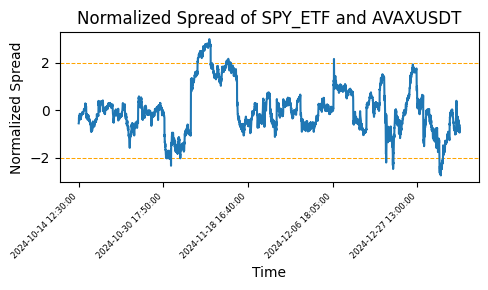

,SPY_ETF,AVAXUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-14 12:30:00,581.80,29.17,552.63,-0.555976,NaN,No action
2024-10-14 12:35:00,581.86,29.17,552.69,-0.544138,-0.555976,No action
2024-10-14 12:40:00,582.14,29.20,552.94,-0.494814,-0.544138,No action
2024-10-14 12:45:00,583.03,29.15,553.88,-0.309355,-0.494814,No action
2024-10-14 12:50:00,582.76,29.17,553.59,-0.366571,-0.309355,No action


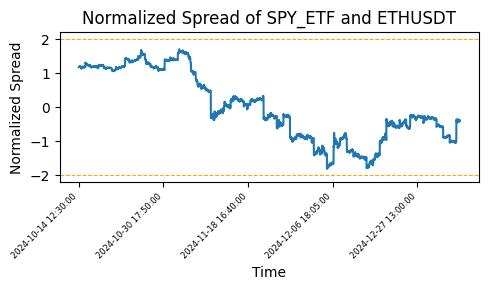

,SPY_ETF,ETHUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-14 12:30:00,581.80,2627.09,-2045.29,1.177548,NaN,No action
2024-10-14 12:35:00,581.86,2625.69,-2043.83,1.180623,1.177548,No action
2024-10-14 12:40:00,582.14,2626.97,-2044.83,1.178517,1.180623,No action
2024-10-14 12:45:00,583.03,2625.72,-2042.69,1.183023,1.178517,No action
2024-10-14 12:50:00,582.76,2623.80,-2041.04,1.186497,1.183023,No action


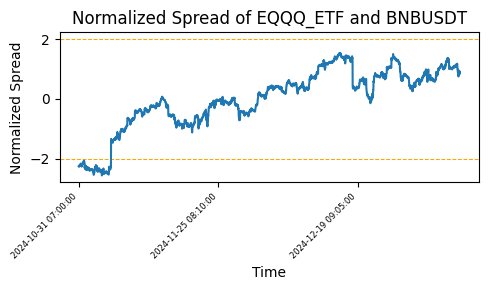

,EQQQ_ETF,BNBUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-31 07:00:00,37990.0,578.2,37411.8,-2.248889,NaN,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:05:00,38001.0,580.1,37420.9,-2.241156,-2.248889,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:10:00,37986.0,579.0,37407.0,-2.252968,-2.241156,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:25:00,38011.0,579.6,37431.4,-2.232233,-2.252968,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 07:35:00,37978.0,577.9,37400.1,-2.258832,-2.232233,"Buy EQQQ_ETF, sell BNBUSDT"


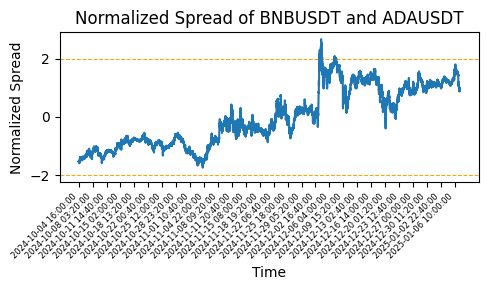

,BNBUSDT,ADAUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-04 16:00:00,556.3,0.3521,555.9479,-1.520989,NaN,No action
2024-10-04 16:05:00,556.5,0.3523,556.1477,-1.517447,-1.520989,No action
2024-10-04 16:10:00,556.0,0.3523,555.6477,-1.526310,-1.517447,No action
2024-10-04 16:15:00,555.9,0.3523,555.5477,-1.528082,-1.526310,No action
2024-10-04 16:20:00,555.5,0.3515,555.1485,-1.535158,-1.528082,No action


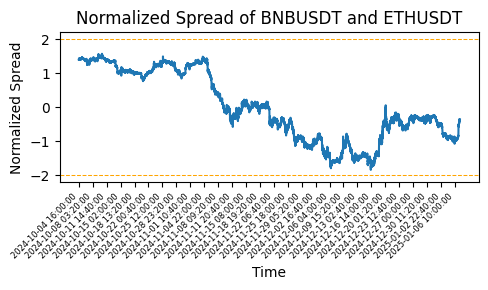

,BNBUSDT,ETHUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-04 16:00:00,556.3,2420.21,-1863.91,1.397404,NaN,No action
2024-10-04 16:05:00,556.5,2420.40,-1863.90,1.397426,1.397404,No action
2024-10-04 16:10:00,556.0,2415.90,-1859.90,1.406057,1.397426,No action
2024-10-04 16:15:00,555.9,2414.47,-1858.57,1.408927,1.406057,No action
2024-10-04 16:20:00,555.5,2413.27,-1857.77,1.410653,1.408927,No action


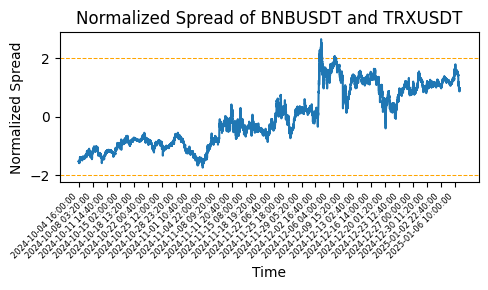

,BNBUSDT,TRXUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-04 16:00:00,556.3,0.1566,556.1434,-1.520241,NaN,No action
2024-10-04 16:05:00,556.5,0.1566,556.3434,-1.516711,-1.520241,No action
2024-10-04 16:10:00,556.0,0.1566,555.8434,-1.525537,-1.516711,No action
2024-10-04 16:15:00,555.9,0.1564,555.7436,-1.527298,-1.525537,No action
2024-10-04 16:20:00,555.5,0.1564,555.3436,-1.534358,-1.527298,No action


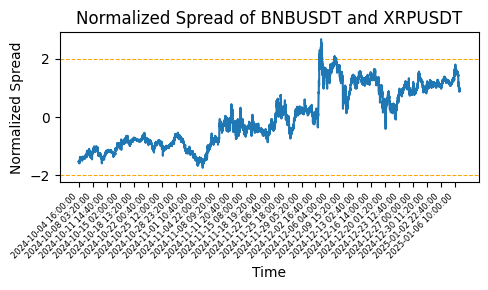

,BNBUSDT,XRPUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-04 16:00:00,556.3,0.5334,555.7666,-1.525508,NaN,No action
2024-10-04 16:05:00,556.5,0.5339,555.9661,-1.521942,-1.525508,No action
2024-10-04 16:10:00,556.0,0.5335,555.4665,-1.530874,-1.521942,No action
2024-10-04 16:15:00,555.9,0.5325,555.3675,-1.532644,-1.530874,No action
2024-10-04 16:20:00,555.5,0.5317,554.9683,-1.539780,-1.532644,No action


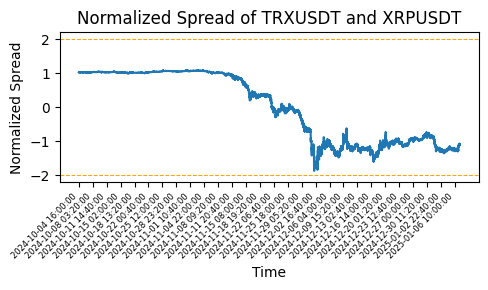

,TRXUSDT,XRPUSDT,Spread,NormalizedSpread,NormalizedSpread_Lag1,TradingSignal
OpenTime,,,,,,
2024-10-04 16:00:00,0.1566,0.5334,-0.3768,1.028190,NaN,No action
2024-10-04 16:05:00,0.1566,0.5339,-0.3773,1.027548,1.028190,No action
2024-10-04 16:10:00,0.1566,0.5335,-0.3769,1.028061,1.027548,No action
2024-10-04 16:15:00,0.1564,0.5325,-0.3761,1.029087,1.028061,No action
2024-10-04 16:20:00,0.1564,0.5317,-0.3753,1.030114,1.029087,No action


In [18]:
def plot_spread(df, X, Y):
    '''
    Plots the normalized spread between two assets. 
    '''
    try:
        fig = plt.figure(figsize=(5,3))
        plt.axhline(2, color='orange', linestyle='--', linewidth=0.75)
        plt.axhline(-2, color='orange', linestyle='--', linewidth=0.75)
        plt.plot(df['NormalizedSpread'])
        if (len(X)>6) & (len(Y)>6):
            plt.gca().xaxis.set_major_locator(plt.IndexLocator(base=1000, offset=0))
        else:
            plt.gca().xaxis.set_major_locator(plt.IndexLocator(base=200, offset=0))
        plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45, ha='right', size=6)
        plt.title(f'Normalized Spread of {X} and {Y}')
        plt.xlabel('Time')
        plt.ylabel('Normalized Spread')
        plt.tight_layout()
        plt.savefig(f'output/normalized_spread_{X}_{Y}.png')
        plt.show();
    except Exception as e:
        print(f'Failed to plot normalized spread: {str(e)}')
        log.error(f'Failed to plot normalized spread: {str(e)}')

for p in pairs:
    tickerX, tickerY = p.split(' ')
    spread_df = process_pairs_series(tickerX, tickerY, df=df_full)
    spread_df['Spread'] = spread_df[tickerX] - spread_df[tickerY]
    # Normalize spread
    spread_df['NormalizedSpread'] = ((spread_df['Spread'] - spread_df['Spread'].mean())
                                     / spread_df['Spread'].std())
    spread_df[f'NormalizedSpread_Lag1'] = spread_df['NormalizedSpread'].shift(1)
    spread_df['TradingSignal'] = 'No action'
    spread_df.loc[spread_df['NormalizedSpread'] < -2, 'TradingSignal'] = f'Buy {tickerX}, sell {tickerY}'
    spread_df.loc[spread_df['NormalizedSpread'] > 2, 'TradingSignal'] = f'Buy {tickerY}, sell {tickerX}'
    plot_spread(spread_df, tickerX, tickerY)
    spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')
    display(spread_df.head())